<h1 style="color:black;text-align:center;font-size:300%;font-family:verdana;">
Support Vector Regressor
</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import GridSearchCV
from IPython.display import display
# removes unnecessary warnings (for nicer looking graphs)
import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv('clean_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527232 entries, 0 to 527231
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Origin                             527232 non-null  object
 1   Destination                        527232 non-null  object
 2   TTT                                527232 non-null  int64 
 3   LOS                                527232 non-null  int64 
 4   Arrival Time                       527232 non-null  object
 5   Return Arrival Time                527232 non-null  object
 6   Onward Departure Airport           527232 non-null  object
 7   Onward Arrival Airport             527232 non-null  object
 8   Return Departure Airport           527232 non-null  object
 9   Return Arrival Airport             527232 non-null  object
 10  Onward Airlines                    527232 non-null  object
 11  Return Airlines                    527232 non-null  

## Correlation-Based Feature Selection & Analysis
Before building the model, we will start with the top 10 correlating features with the price for a baseline model.  
Later, we will test adding more features and compare the performance using evaluation tools (R², MAE, RMSE).

### Steps:  
1. Select only numeric features.
2. Remove constant columns.
3. Compute correlations with price.
4. Visualize correlations with a heatmap.

This helps identify key predictors and remove irrelevant features.  

📌 Correlation between numeric variables and flight price:
Price(NIS)                           1.000000
Total Flight Duration(min)           0.439293
Total Onward Flight Duration(min)    0.409827
Total Return Flight Duration(min)    0.386589
Carry-ons                            0.198557
Departure Month                      0.081097
Checked Bags                         0.039901
Total Connections                    0.038113
Onward Flight Connections            0.027944
Return Flight Connections            0.027640
Return Month                         0.015533
Departure Weekday                   -0.000305
Onward Connection Duration(min)     -0.001828
Return Connection Duration(min)     -0.002180
LOS                                 -0.004541
Departure Time Category Num         -0.018463
Return Time Category Num            -0.042170
Return Weekday                      -0.042786
Return Departure Airport Distance   -0.061253
TTT                                 -0.062268
Return Arrival Airport

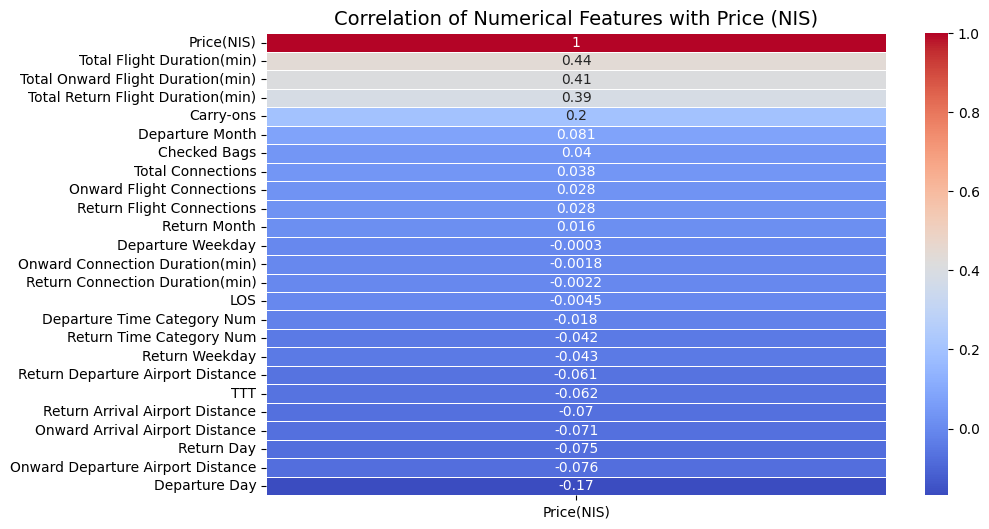

In [3]:
# Selecting only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Removing constant columns (columns with only one unique value)
numeric_data = numeric_data.loc[:, numeric_data.nunique() > 1]

print("📌 Correlation between numeric variables and flight price:")
correlation_with_price = numeric_data.corr()['Price(NIS)'].sort_values(ascending=False)
print(correlation_with_price)

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr()[['Price(NIS)']].sort_values(by='Price(NIS)', ascending=False), 
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation of Numerical Features with Price (NIS)", fontsize=14)
plt.show()

In [4]:
correlation_with_price = abs(correlation_with_price).sort_values(ascending=False)
correlation_with_price.head(12)

Price(NIS)                           1.000000
Total Flight Duration(min)           0.439293
Total Onward Flight Duration(min)    0.409827
Total Return Flight Duration(min)    0.386589
Carry-ons                            0.198557
Departure Day                        0.168935
Departure Month                      0.081097
Onward Departure Airport Distance    0.076258
Return Day                           0.074558
Onward Arrival Airport Distance      0.070608
Return Arrival Airport Distance      0.070343
TTT                                  0.062268
Name: Price(NIS), dtype: float64

In [5]:
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Preparation  

Before training the model, we define the features (X) and target variable (y).  
We must also scale the numerical data because we want even weights between the different features.    
SVR works best with with data centered around mean = 0, variance = 1 so we use the standard scaler.

### Steps:  
1. Select all relevant features. 
2. Convert the nominal features into categories and create dummies so that the model will be able to understand them properlly.   
3. Split the data into training (70%) and testing (30%) sets.  
4. Print dataset sizes to verify the split.  
5. Scale the features for both X_train and X_test

This ensures the model is trained on one part of the data and evaluated on unseen data.  


In [6]:
X = data[[
    "Total Onward Flight Duration(min)", "Total Return Flight Duration(min)", "Carry-ons",
    "Departure Day", "Departure Month", "Onward Departure Airport Distance", "Return Day",
    "Onward Arrival Airport Distance", "Return Arrival Airport Distance", "TTT"
]]  
y = data["Price(NIS)"]
X.head()

,Total Onward Flight Duration(min),Total Return Flight Duration(min),Carry-ons,Departure Day,Departure Month,Onward Departure Airport Distance,Return Day,Onward Arrival Airport Distance,Return Arrival Airport Distance,TTT
0,70,65,0,7,3,64,8,25,45,1
1,70,75,0,7,3,64,8,25,23,1
2,70,65,0,7,3,64,8,25,45,1
3,70,70,0,7,3,64,8,25,45,1
4,70,70,0,7,3,64,8,25,45,1


### * Since the features we picked are all numeric, there is no need to convert any into categories.

In [7]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (369062, 10), Test set: (158170, 10)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Initial Support Vector Model
- Train a basic **Support Vector Regressor**.  
- Predict flight prices on the test set.  
- Evaluate performance using **MAE**, **MSE** and **R² Score**. 


In [9]:
# svr_model = SVR(kernel='rbf', C=1.0, epsilon=1.0)
# svr_model.fit(X_train_scaled, y_train)

# # predictions
# y_pred = svr_model.predict(X_test_scaled)

# # Checking Model Performance
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred, squared=False)
# rmse = math.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R² Score: {r2:.4f}")

❗ After trying to train the standard model for over 50 minutes, we checked wether this long training period is normal.  
  
❌ We decided to stop the training after discovering that the algorithms run time is between `O(n^2 * m)` and `O(n^3 * m)`.  
  
💡 We though of a different approach where we split the data into batches, training each batch to find support vectors seperatly and then train a final SVR on the collected support vectors.



In [10]:
# batch_size = 5000  # Adjust based on available memory
# n_batches = int(np.ceil(len(X) / batch_size))

# X_scaled = scaler.fit_transform(X)  # Scale entire dataset

# all_support_vectors = []
# all_support_y = []

# for i in range(n_batches):
#     print(f"Processing batch {i+1}/{n_batches}...")
    
#     # Get batch data
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, len(X))
    
#     X_batch = X_scaled[start_idx:end_idx]
#     y_batch = y[start_idx:end_idx]
#     y_batch = np.array(y_batch)
    
#     # Train SVR on batch
#     svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
#     svr.fit(X_batch, y_batch)
    
#     # Extract support vectors
#     support_indices = svr.support_
#     all_support_vectors.append(X_batch[support_indices])
#     all_support_y.append(y_batch[support_indices])

# # Combine all collected support vectors
# X_support_combined = np.vstack(all_support_vectors)
# y_support_combined = np.hstack(all_support_y)

# # Train final SVR model using the collected support vectors
# final_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# final_svr.fit(X_support_combined, y_support_combined)

# print("Final SVR model trained on collected support vectors.")

❗ This too did not work so well and we decided to stop the process mid-way again.  

💡 We learned that the `rbf` kurnel handles non-linear relationships, following intricate data patterns, thus predicting a very precise hyperplane.  
Is not suited for large datasets due to large complexity times like we encountered. 

💡The `LinearSVD`, altough slightly less precise, is preffered to handling these situations due to it's simpler approach that uses linear regression  
with epsilon-insensitive loss, that scales linearly with the number of samples.



In [11]:
svr_model = LinearSVR(C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# predictions
y_pred = svr_model.predict(X_test_scaled)

# Checking Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (TMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 129.03
Mean Squared Error (MSE): 31571.26
Root Mean Squared Error (TMSE): 177.68
R² Score: 0.2644


### Due to very low scores, we want to see for ourselves the models predictions:

In [12]:
# Creating a DataFrame with actual vs. predicted prices
comparison_df = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": y_pred
})

# Adding an error column (difference between actual and predicted)
comparison_df["Error"] = comparison_df["Predicted Price"] - comparison_df["Actual Price"]

# Adding an indicator column for over/under prediction
comparison_df["Prediction Direction"] = np.where(
    comparison_df["Error"] > 0, "⬆ Over", "⬇ Under"
)

# Styling: align all columns to center
styled_table = (comparison_df
                .head(10)
                .style
                .set_properties(**{'text-align': 'center'})  # Apply to all columns
                .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])  # Center column headers
)

# Display the table
display(styled_table)

,Actual Price,Predicted Price,Error,Prediction Direction
0,761,738.001589,-22.998411,⬇ Under
1,632,592.248463,-39.751537,⬇ Under
2,433,501.168681,68.168681,⬆ Over
3,740,353.686176,-386.313824,⬇ Under
4,1162,675.925325,-486.074675,⬇ Under
5,446,712.067372,266.067372,⬆ Over
6,944,664.145975,-279.854025,⬇ Under
7,529,611.603889,82.603889,⬆ Over
8,832,708.683974,-123.316026,⬇ Under
9,631,647.043591,16.043591,⬆ Over


### Trying to search for the best hyper parameters to improve performance:

In [13]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(LinearSVR(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 1, 'epsilon': 0.5}


In [14]:
svr_model = LinearSVR(**grid_search.best_params_)
svr_model.fit(X_train_scaled, y_train)

# predictions
y_pred = svr_model.predict(X_test_scaled)

# Checking Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 129.03
Mean Squared Error (MSE): 31605.17
Root Mean Squared Error (RMSE): 177.78
R² Score: 0.2636


## **Final Thoughts** 
* Even after tuning using hyperparameters, our metrics show us that the performance of `LinearSVR` is very poor.

* We scaled our data so high noise should not be the cause for these results.

* We can infer that the reason is due to us using a linear model with features that correlate quite poorly with the target feature(non-linear relationships).

* Continuing to try different ways to maximize the algorithm's performance is an option but due to the very low start point  
we prefer to try a different algorithm that is perhaps more suited to our data.
___


<h1 style="color:black;text-align:center;font-size:300%;font-family:verdana;">
K-Neighbors Regressor
</h1>

## Following our conclusion to use a non-linear model that is suited for large datasets, we have decided to use K-Neighbors Regressor

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

### This time we went for a different approach, taking the top variables for both:
- Highest correlation to target.

- Highest variance of values.
___

## Variance Analysis
Before building the model, we analyze the variance between each numerical feature.  

This helps identify key predictors and remove irrelevant features.  


In [16]:
print("📌 Variance of numeric variables:")
varValues = numeric_data.var().sort_values(ascending=False)
varValues.head(12)

📌 Variance of numeric variables:


Price(NIS)                           42998.931048
Total Flight Duration(min)            6641.891101
Total Return Flight Duration(min)     2108.078443
Total Onward Flight Duration(min)     1940.133049
Return Connection Duration(min)        583.443728
Onward Connection Duration(min)        474.037842
Return Departure Airport Distance      285.425602
Onward Departure Airport Distance      282.599173
Return Arrival Airport Distance        273.195613
Onward Arrival Airport Distance        267.261367
Return Day                              82.806741
Departure Day                           80.996120
dtype: float64

#### We merge both the highest correlating features and the highest variance:

In [17]:
# Using features with highest correlation to target and highest variance
XCombo = data[[
    "Total Return Flight Duration(min)", "Total Onward Flight Duration(min)", "Carry-ons",
    "Return Connection Duration(min)", "Onward Connection Duration(min)", "Return Departure Airport Distance",
    "Onward Departure Airport Distance", "Return Arrival Airport Distance",
    "Onward Arrival Airport Distance", "Return Day", "Departure Day", "TTT", "Departure Month"
]]  
yCombo = data["Price(NIS)"]
XCombo.head()

,Total Return Flight Duration(min),Total Onward Flight Duration(min),Carry-ons,Return Connection Duration(min),Onward Connection Duration(min),Return Departure Airport Distance,Onward Departure Airport Distance,Return Arrival Airport Distance,Onward Arrival Airport Distance,Return Day,Departure Day,TTT,Departure Month
0,65,70,0,0,0,13,64,45,25,8,7,1,3
1,75,70,0,0,0,13,64,23,25,8,7,1,3
2,65,70,0,0,0,25,64,45,25,8,7,1,3
3,70,70,0,0,0,13,64,45,25,8,7,1,3
4,70,70,0,0,0,13,64,45,25,8,7,1,3


In [18]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XCombo, yCombo, test_size=0.3, random_state=101)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (369062, 13), Test set: (158170, 13)


### Scaling the data so that features have even weight, thus large noise (large distances) won't bias results: 

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Initial kNN Model
- Train a **K Nearest Neighbors Regressor**.  
- Predict flight prices on the test set.  
- Evaluate performance using **MSE**, **RMSE**, **MAE** and **R² Score**. 

In [20]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Initial Model Performance on Test Set:\n MAE: {mae:.4f}\n MSE: {mse:.4f}\n RMSE: {rmse:.4f}\n R²: {r2:.4f}")

Initial Model Performance on Test Set:
 MAE: 61.8513
 MSE: 7409.8646
 RMSE: 86.0806
 R²: 0.8274


### Model Performance  
__________________________________
- **MAE:** 61.8513 → Measures the average absolute error in predictions.  
- **MSE:** 7409.8646 → Measures the average squared error in predictions.  
- **RMSE:** 86.0806 → Measures the average error in predictions.  
- **R² Score:** 0.8274 → The model explains 82.74% of the variance in flight prices.  

### Insights and Next Steps  
___________________
- The model gives an **ok starting point**, but it needs to be improved.  
- To make it more accurate, we check different **K Number of Neighbors** to find the most suited range.  
  

## **Cross Validation**
We will first assess how the model generally acts with different K's to have an initial estimation of the perfromance.  
---

✅ If the performance is reasonable, we will proceed with GridSearchCV for fine-tuning.  
✅ We do this while considering the results of the cross validation with limited liability.

In [21]:
error = []
for k in range(2,11):
    knn = KNeighborsRegressor(n_neighbors=k)
    mse = -cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean() 
    #All scorer objects follow the convention that higher return values are better than lower return values.
    #Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error,
    #are available as ‘neg_mean_squared_error’ which return the negated value of the metric.
    error.append(mse)
    print(k)

2
3
4
5
6
7
8
9
10


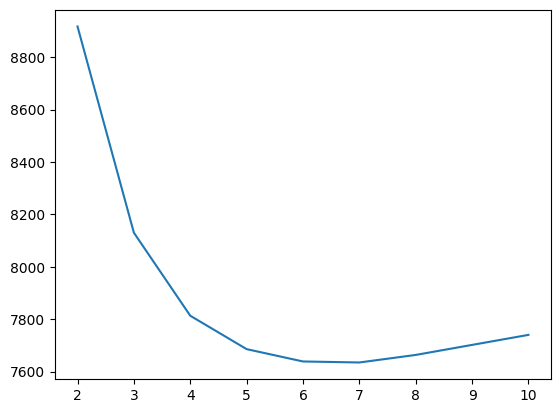

In [22]:
plt.plot(range(2,11), error)
plt.show()

In [23]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Post CVP Model Performance on Test Set:\n MAE: {mae:.4f}\n MSE: {mse:.4f}\n RMSE: {rmse:.4f}\n R²: {r2:.4f}")

Post CVP Model Performance on Test Set:
 MAE: 61.9708
 MSE: 7334.1022
 RMSE: 85.6394
 R²: 0.8291


### Model Evaluation After K change
_____________________________  

- **Updated MSE:** 61.9708 
- **Updated MSE:** 7334.1022 
- **Updated RMSE:** 85.6394  
- **Updated R² Score:** 0.8291     
  
Almost no change compared to the previous model.

### Key Takeaways:  
- The default K value is 5, and as seen in the graph, the **difference between the error is minor**.
- This confirms that if the K is kept within a certain range, its value **has very minor influence**.
- Ofcourse this is only when K is **between a certain range**.


## Hyperparameter Tuning with GridSearchCV
______________________________________________ 

 Why Do This?  The model works fine, but we want to **make it better** by finding the best settings.  
**GridSearchCV** automatically tests different parameter values and selects the best combination.  
  
How It Works:  

**1️⃣ Define Parameters to Test**  
We choose key settings to optimize:  
`n_neighbors` → Picks how many closest data points to use.  
`weights` → Decide if all points in each 'neighborhood' have the same weight or different weight based on distance.  
`metric` → Calculate based on different distance measure.  

**2️⃣ Run GridSearchCV**  
The system trains multiple models with different parameter combinations.  
It uses cross-validation to ensure the results are reliable.  

**3️⃣ Select the Best Model**  
After testing, we pick the best-performing parameter set.  
We use these settings to train a final, improved model.  

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [6, 7, 8, 10, 12, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"✅ Best hyperparameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 28 candidates, totalling 140 fits
✅ Best hyperparameters found: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [24]:
final_knn = KNeighborsRegressor(metric = 'manhattan', n_neighbors = 15, weights = 'distance')
final_knn.fit(X_train_scaled, y_train)

y_pred = final_knn.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Final Model Performance on Test Set:\n MAE: {mae:.4f}\n MSE: {mse:.4f}\n RMSE: {rmse:.4f}\n R²: {r2:.4f}")

Final Model Performance on Test Set:
 MAE: 57.6242
 MSE: 6619.5820
 RMSE: 81.3608
 R²: 0.8458


## Results After Hyperparameter Tuning
We used **GridSearchCV** to find the best hyperparameters for the kNN model.  
The tuning process tested 140 different models using 5-fold cross-validation, and we selected the best configuration.

### Best Parameters Found  
- **`n_neighbors`**: `15`  
- **`weights`**: `distance`  
- **`metric`**: `manhattan`  

---

### Performance Comparison  

| Metric                         | Before Tuning  | After Tuning  | Improvement  |
|--------------------------------|----------------|---------------|--------------|
| **Mean Absolute Error (MAE)**    | 61.97        | **57.62**   | ✅ -4.35    |
| **Mean Squared Error (MSE)**    | 7334.10        | **6619.58**   | ✅ -714.52    |
| **Root Mean Squared Error (RMSE)**    | 85.63        | **81.36**   | ✅ -4.27    |
| **R² Score**                    | 0.8291         | **0.8458**    | ✅ +2.01%    |

---


## Actual vs. Predicted Prices  
- We compare **real flight prices** with the **predicted prices** from the optimized kNN.  
- Displayed the first 10 rows to see how close the predictions are.  
---

✅ The predictions are mostly close to the real prices.  
✅ Some differences exist, so there’s room for improvement.  


In [25]:
from IPython.display import display

# Creating a DataFrame with actual vs. predicted prices
comparison_df = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": y_pred
})

# Adding an error column (difference between actual and predicted)
comparison_df["Error"] = comparison_df["Predicted Price"] - comparison_df["Actual Price"]

# Adding an indicator column for over/under prediction
comparison_df["Prediction Direction"] = np.where(
    comparison_df["Error"] > 0, "⬆ Over", "⬇ Under"
)

# Styling: align all columns to center
styled_table = (comparison_df
                .head(10)
                .style
                .set_properties(**{'text-align': 'center'})  # Apply to all columns
                .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])  # Center column headers
)

# Display the table
display(styled_table)

,Actual Price,Predicted Price,Error,Prediction Direction
0,761,678.000000,-83.000000,⬇ Under
1,632,711.466667,79.466667,⬆ Over
2,433,433.571429,0.571429,⬆ Over
3,740,783.000000,43.000000,⬆ Over
4,1162,1107.333333,-54.666667,⬇ Under
5,446,414.000000,-32.000000,⬇ Under
6,944,913.375000,-30.625000,⬇ Under
7,529,662.666667,133.666667,⬆ Over
8,832,701.466667,-130.533333,⬇ Under
9,631,680.533333,49.533333,⬆ Over


## **Error Analysis**
We analyzed **prediction errors** (Actual - Predicted) to evaluate model accuracy.

---

✅ Most predictions are close, but some errors are large.  
✅ No strong bias, but the model struggles with high-priced flights.  
✅ Random error distribution suggests overall good performance.  

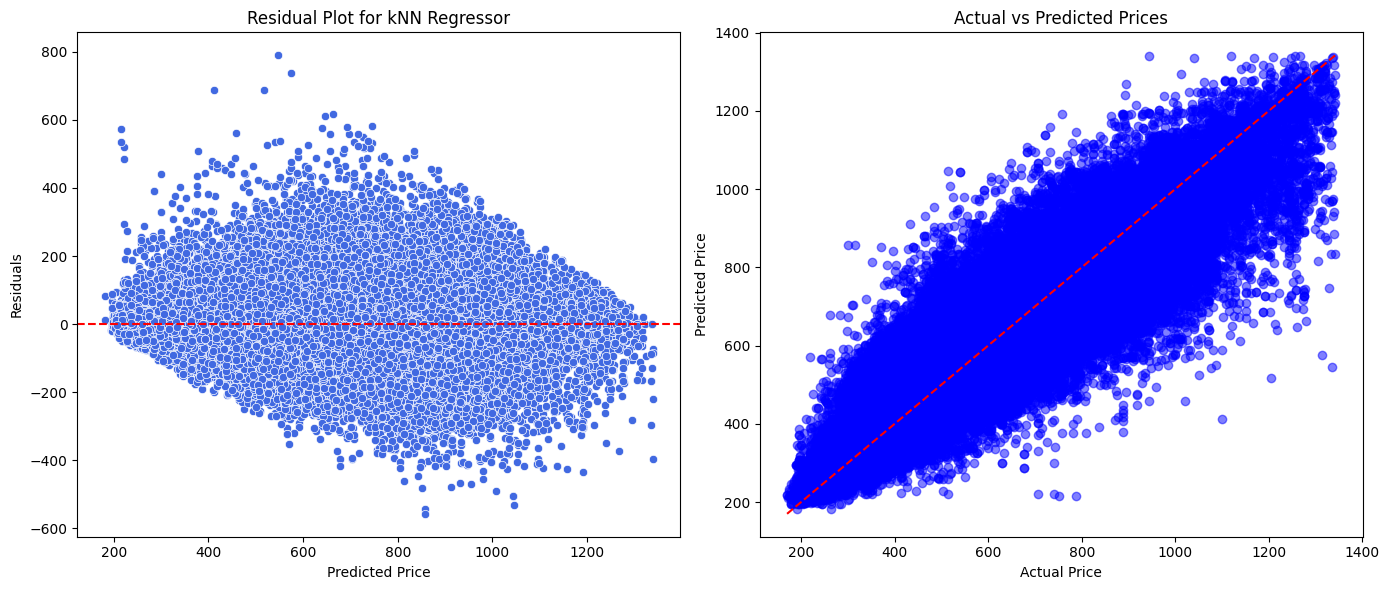

In [26]:
# Calculate residuals
residuals = y_test - y_pred

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 🔹 Residual Plot
sns.scatterplot(x=y_pred, y=residuals, color='royalblue', ax=axes[0])
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Price')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot for kNN Regressor')

# 🔹 Actual vs. Predicted Prices
axes[1].scatter(y_test, y_pred, alpha=0.5, color="blue")
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="red")  # Ideal line
axes[1].set_xlabel("Actual Price")
axes[1].set_ylabel("Predicted Price")
axes[1].set_title("Actual vs Predicted Prices")

plt.tight_layout()
plt.show()

## **Error Analysis with Residual & Actual vs. Predicted Plots**  
---

### **Residual Plot (Left Graph)**  
- Shows prediction errors (Actual - Predicted) against predicted prices.  
- The residuals are spread somewhat evenly around zero, indicating that there is no severe systematic bias.
- However, the residual variance appears to increase with predicted price, meaning the model struggles more with higher price predictions. 
- There are some noticeable outliers with very high residuals, suggesting that kNN is struggling with certain price ranges.


---

### **Actual vs. Predicted Prices (Right Graph)**  
- Compares actual flight prices to model predictions.  
- Most points are clustered along the diagonal, indicating that the model generally predicts well.
- There is some noticeable spread, especially at higher prices, meaning kNN is less precise for expensive flights. 
- Some points deviate significantly from the diagonal, suggesting potential underfitting or difficulties capturing price variability.  


---

### **Key Takeaways:**  
- The model does reasonably well overall but struggles with high-price flights.
- kNN might be smoothing out extreme values, causing higher residuals for expensive flights.

## **Site Comparison**
We will look into the differences between the two sites for both performance evaluation and feature dependency.

In [27]:
momondo = data[data['Site'] == 'Momondo']
kayak = data[data['Site'] == 'Kayak']

In [28]:
site_diff = momondo['Site'].value_counts()[0] - kayak['Site'].value_counts()[0]
site_diff

np.int64(-3440)

### Kayak has 3,440 more records, but since each site's records are vastly higher, the difference is negligible.

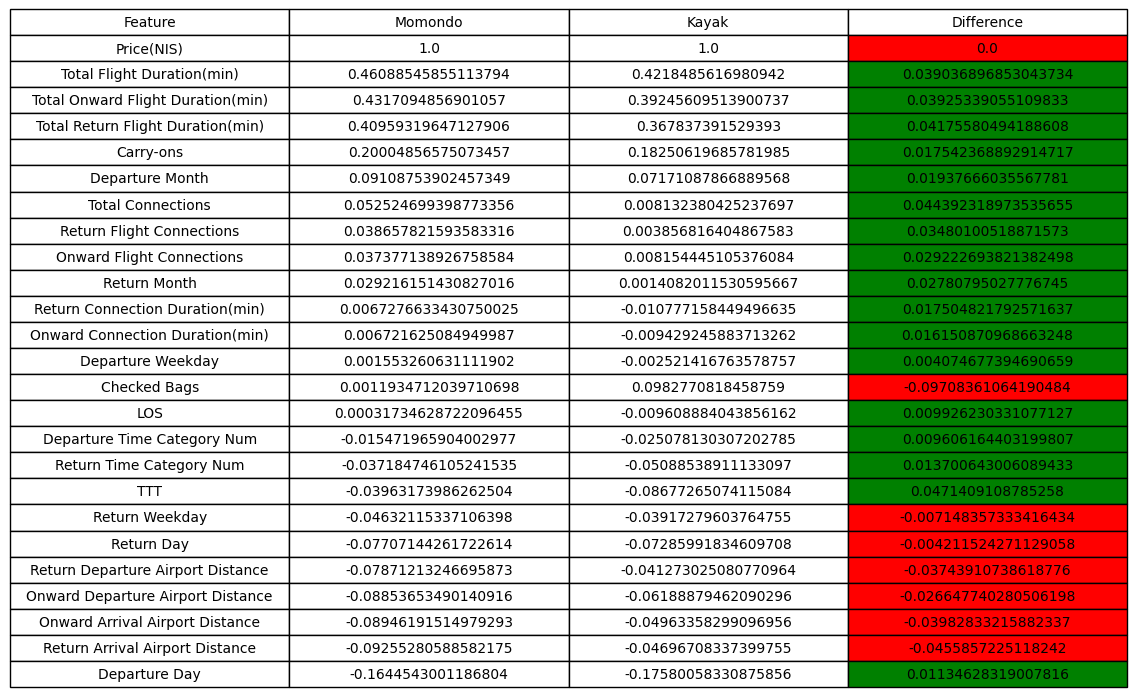

In [29]:
# Selecting only numeric columns
momo_numeric_data = momondo.select_dtypes(include=['number'])
kaya_numeric_data = kayak.select_dtypes(include=['number'])

# Removing constant columns (columns with only one unique value)
momo_numeric_data = momo_numeric_data.loc[:, momo_numeric_data.nunique() > 1]
kaya_numeric_data = kaya_numeric_data.loc[:, kaya_numeric_data.nunique() > 1]

momo_correlation_with_price = momo_numeric_data.corr()['Price(NIS)'].sort_values(ascending=False)
kaya_correlation_with_price = kaya_numeric_data.corr()['Price(NIS)'].sort_values(ascending=False)


# Merge correlations into a single DataFrame
correlation_df = pd.DataFrame({'Feature': momo_correlation_with_price.index, 
                               'Momondo': momo_correlation_with_price.values, 
                               'Kayak': kaya_correlation_with_price.reindex(momo_correlation_with_price.index).values})

correlation_df['Difference'] = correlation_df['Momondo'] - correlation_df['Kayak']

# Create a figure
fig, ax = plt.subplots(figsize=(12, 7))
ax.axis("off")

# Create a table
table = ax.table(cellText=correlation_df.values, 
                 colLabels=correlation_df.columns, 
                 cellLoc="center", 
                 loc="center")

for i, row in enumerate(correlation_df['Difference']):
    # If the difference is positive, color the cell green, otherwise red
    color = 'green' if row > 0 else 'red'
    table[(i + 1, 3)].set_facecolor(color)  # 3 corresponds to the 'Difference' column

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.4, 1.4)  # Adjust table size

plt.tight_layout()
plt.show()

### 📌 Our numeric features correlate a bit better with the price on **Momondo** then on Kayak, but not a huge difference.  

## Variance check:

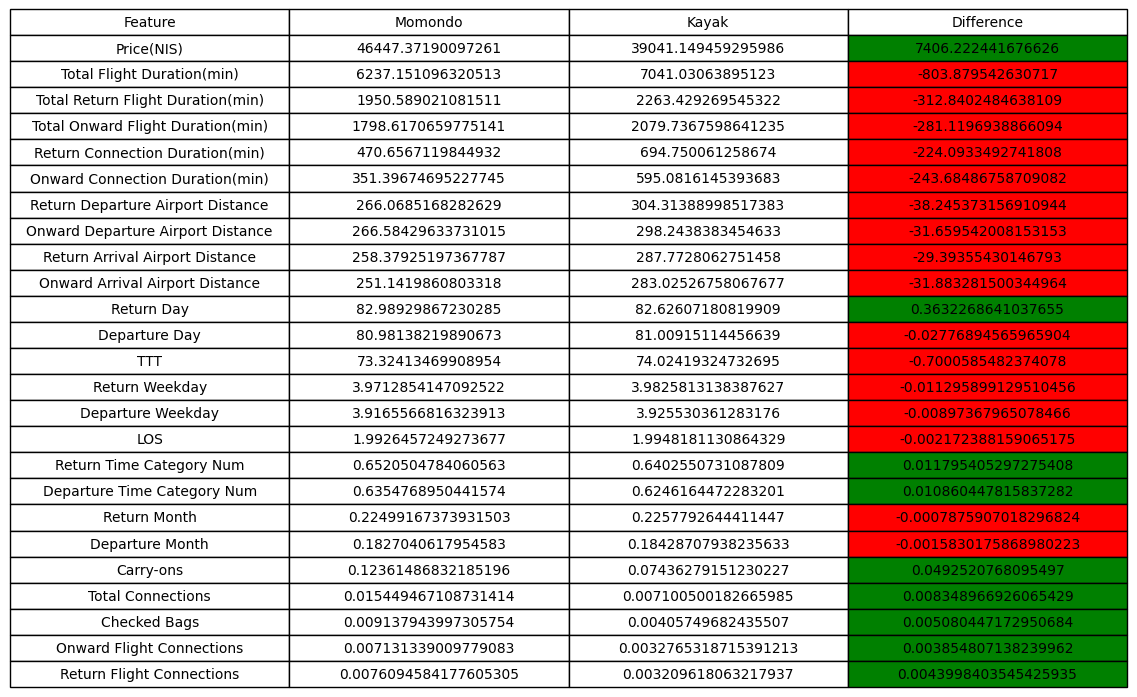

In [30]:
momoVarValues = momo_numeric_data.var().sort_values(ascending=False)
kayaVarValues = kaya_numeric_data.var().sort_values(ascending=False)

var_df = pd.DataFrame({'Feature': kayaVarValues.index, 
                       'Momondo': momoVarValues.reindex(kayaVarValues.index).values, 
                       'Kayak': kayaVarValues.values})

var_df['Difference'] = var_df['Momondo'] - var_df['Kayak']

# Create a figure
fig, ax = plt.subplots(figsize=(12, 7))
ax.axis("off")

# Create a table
table = ax.table(cellText=var_df.values, 
                 colLabels=var_df.columns, 
                 cellLoc="center", 
                 loc="center")

for i, row in enumerate(var_df['Difference']):
    # If the difference is positive, color the cell green, otherwise red
    color = 'green' if row > 0 else 'red'
    table[(i + 1, 3)].set_facecolor(color)  # 3 corresponds to the 'Difference' column

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.4, 1.4)  # Adjust table size

plt.tight_layout()
plt.show()

### 📌 Most of the top features are more varied in **Kayak** (except for the target itself).
### 💡 This indicates that the model will work better for each site based on different feature selection based on different criteria.

In [31]:
# based on highest correlation with price
XMom = momondo[[
    'Total Onward Flight Duration(min)', 'Total Return Flight Duration(min)', 'Carry-ons',
    'Departure Month', 'Total Connections', 'Return Flight Connections',
    'Onward Flight Connections', 'Return Month'
]]
yMom = momondo["Price(NIS)"]

# based on highest variance
XKay = kayak[[
    'Total Return Flight Duration(min)', 'Total Onward Flight Duration(min)', 'Return Connection Duration(min)',
    'Onward Connection Duration(min)', 'Return Departure Airport Distance', 'Onward Departure Airport Distance',
    'Return Arrival Airport Distance', 'Onward Arrival Airport Distance',
]]
yKay = kayak["Price(NIS)"]

In [33]:
# Splitting into training and testing sets
X_trainM, X_testM, y_trainM, y_testM = train_test_split(XMom, yMom, test_size=0.3, random_state=101)
X_train_scaledM = scaler.fit_transform(X_trainM)
X_test_scaledM = scaler.transform(X_testM)

X_trainK, X_testK, y_trainK, y_testK = train_test_split(XKay, yKay, test_size=0.3, random_state=101)
X_train_scaledK = scaler.fit_transform(X_trainK)
X_test_scaledK = scaler.transform(X_testK)

## Using the same hyperparameters as our combined model:

In [34]:
knnM = KNeighborsRegressor(metric='manhattan', n_neighbors=15, weights='distance')
knnM.fit(X_train_scaledM, y_trainM)
y_predM = knnM.predict(X_test_scaledM)
maeM = mean_absolute_error(y_testM, y_predM)
mseM = mean_squared_error(y_testM, y_predM)
rmseM = math.sqrt(mseM)
r2M = r2_score(y_testM, y_predM)

knnK = KNeighborsRegressor(metric='manhattan', n_neighbors=15, weights='distance')
knnK.fit(X_train_scaledK, y_trainK)
y_predK = knnK.predict(X_test_scaledK)
maeK = mean_absolute_error(y_testK, y_predK)
mseK = mean_squared_error(y_testK, y_predK)
rmseK = math.sqrt(mseK)
r2K = r2_score(y_testK, y_predK)

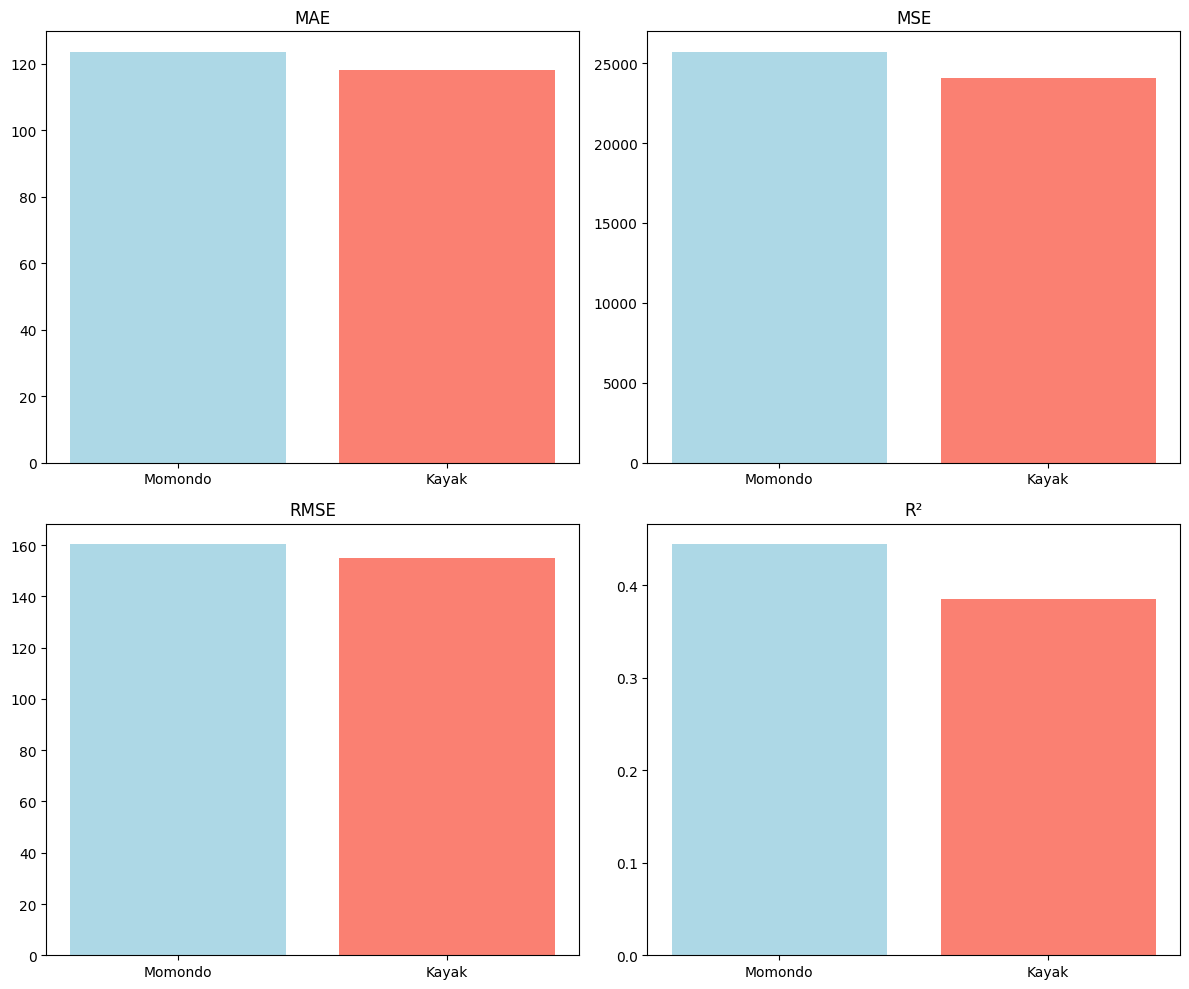

In [35]:
# Metrics for the two models
metrics = ['MAE', 'MSE', 'RMSE', 'R²']
model_1_metrics = [maeM, mseM, rmseM, r2M]
model_2_metrics = [maeK, mseK, rmseK, r2K]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Set the positions for each metric
axs[0, 0].bar(['Momondo', 'Kayak'], [maeM, maeK], color=['lightblue', 'salmon'])
axs[0, 0].set_title('MAE')

axs[0, 1].bar(['Momondo', 'Kayak'], [mseM, mseK], color=['lightblue', 'salmon'])
axs[0, 1].set_title('MSE')

axs[1, 0].bar(['Momondo', 'Kayak'], [rmseM, rmseK], color=['lightblue', 'salmon'])
axs[1, 0].set_title('RMSE')

axs[1, 1].bar(['Momondo', 'Kayak'], [r2M, r2K], color=['lightblue', 'salmon'])
axs[1, 1].set_title('R²')

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()

# Comparison:
- Momondo's scores are slightly better than Kayak's.
- However they both score very low in comparison to the merged data.
- We can try and tune each subset's hyper parameters but a vast change won't be likely.

# Concerns that arise:
- With the full dataset, the model may have been overfitting to the data.
- The full dataset may have had more diversity or a broader representation of patterns, allowing the kNN model to perform better.
- The optimal K might change based on the size and distribution of each dataset.

# Summary:
Splitting the data introduces new challenges due to smaller datasets, potential overfitting, and site-specific differences.  
   
The model might not generalize as well to the smaller subsets, which explains the drop in scores.

